<a href="https://colab.research.google.com/github/craigm-c/apoferritin_object_detector/blob/main/Apoferritin_detector_yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install modules and importing data

In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/yolo_data .
!cp -r /content/drive/MyDrive/yolo_data/dataset.yaml .

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.135 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.2/78.2 GB disk)


# Summary

This notebook utilizes the 'yolov8m.pt' model as a starting point to initialize and train an object detector using Yolov8 from Ultralytics. The objective is to identify instances of the apoferritin protein complex in cryo-EM data for single particle reconstruction.

The notebook begins by loading the 'yolov8m.pt' model, which serves as a pre-trained model with weights learned from a large dataset. The necessary hyperparameters for the Yolov8 model are configured. These hyperparameters include parameters such as learning rate, batch size, optimizer choice, weight decay, and intersection over union (IOU) threshold. The model is trained through multiple iterations, optimizing its parameters to accurately detect the target protein complex.

To enhance the model's accuracy further, hyperparameter optimization techniques are employed. These techniques involve systematically adjusting the hyperparameters to find the optimal configuration. This iterative optimization process ensures the model's ability to effectively detect instances of the apoferritin protein complex.

Finally, the trained model is evaluated using standard evaluation metrics for object detection, calculating the mean average precision (mAP) at IOU thresholds of 0.50 and 0.75. The resulting mAP50 of 0.961 and mAP75 of 0.925 demonstrate the high accuracy of the model in successfully detecting instances of the apoferritin protein complex within the cryo-EM data.


# Visualising data

Apoferritin proteins can be seen as circular objects in the image below

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

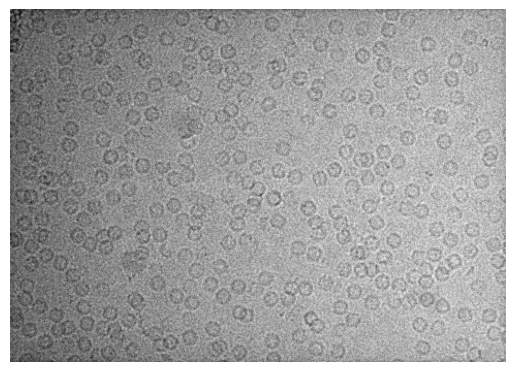

In [ ]:
image_path = '/content/yolo_data/images/train/apo_good_11.jpg'

image = mpimg.imread(image_path)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

# Importing modules for model initalisation and hyperparameter tuning

In [ ]:
import pandas as pd
from ultralytics import YOLO
from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

# Intialising model and performing rough randomised hyperparameter tuning

In [1]:
results = [['learning_rate', 'batch_size', 'optimizer', 'weight_decay', 'iou', 'mAP50', 'mAP75']]

param_grid = {
            'learning_rate':[0.0001, 0.001, 0.01],
            'batch_size':[16, 32, 64],
            'optimizer':['SGD', 'Adamax', 'RAdam'],
            'weight_decay':[0.0001, 0.001],
            'iou':[0.3, 0.5, 0.7]
}

grid = ParameterSampler(param_grid,n_iter=20)


for parameters in grid:
    learning_rate = parameters['learning_rate']
    batch_size = parameters['batch_size']
    optimizer = parameters['optimizer']
    weight_decay = parameters['weight_decay']
    iou = parameters['iou']

    model = YOLO('yolov8m.pt')
    model.train(data='dataset.yaml', epochs=200, batch=batch_size,  imgsz=640, optimizer=optimizer, cos_lr=True, lr0=learning_rate, weight_decay=weight_decay, iou=iou)
    print('=============================================================================================')
    print(learning_rate, batch_size, optimizer, weight_decay, weight_decay, iou)
    print('=============================================================================================')
    metrics = model.val()
    results.append([learning_rate, batch_size, optimizer, weight_decay, iou, metrics.box.map50, metrics.box.map75])
    model.predict('/content/yolo_data/images/test/FoilHole_8910334_Data_8911682_8911684_20220609_105332.jpg', save =True, save_txt = True, show_labels=False)

# Showing parameters in addition to associated mAP50 and	mAP75 metrics from hyperparameter tuning

In [ ]:
df = pd.DataFrame(results[1:], columns=results[0])

In [ ]:
df.head(20)

learning_rate  batch_size optimizer  weight_decay  iou     mAP50     mAP75
0          0.0010          64       SGD        0.0010  0.7  0.956252  0.923013
1          0.0001          64     RAdam        0.0001  0.3  0.938754  0.913409
2          0.0001          16       SGD        0.0010  0.7  0.633802  0.282138
3          0.0010          64       SGD        0.0010  0.5  0.960533  0.925189
4          0.0100          16     RAdam        0.0001  0.7  0.952179  0.937002
5          0.0001          64     RAdam        0.0010  0.5  0.941013  0.918284
6          0.0001          16       SGD        0.0001  0.7  0.663093  0.316377
7          0.0100          64     RAdam        0.0010  0.3  0.903635  0.852049
8          0.0001          32     RAdam        0.0001  0.3  0.916394  0.833528
9          0.0010          64       SGD        0.0010  0.3  0.960901  0.925189
10         0.0001          64       SGD        0.0010  0.3  0.896243  0.757714
11         0.0100          32     RAdam        0.0001  0.5  0.907271  0.852503
12         0.0001          16       SGD        0.0010  0.5  0.683295  0.296072
13         0.0100          64    Adamax        0.0001  0.3  0.675511  0.599483
14         0.0010          16    Adamax        0.0010  0.5  0.948383  0.937165
15         0.0010          32       SGD        0.0001  0.3  0.938566  0.915681
16         0.0001          32     RAdam        0.0010  0.3  0.915862  0.837099
17         0.0100          64       SGD        0.0010  0.5  0.948582  0.938618
18         0.0010          16    Adamax        0.0010  0.7  0.944055  0.933074
19         0.0001          16     RAdam        0.0010  0.7  0.856210  0.733309

In [ ]:
df_sorted = df.sort_values('mAP50', ascending=False)

In [ ]:
df_sorted.head(20)

learning_rate  batch_size optimizer  weight_decay  iou     mAP50     mAP75
9          0.0010          64       SGD        0.0010  0.3  0.960901  0.925189
3          0.0010          64       SGD        0.0010  0.5  0.960533  0.925189
0          0.0010          64       SGD        0.0010  0.7  0.956252  0.923013
4          0.0100          16     RAdam        0.0001  0.7  0.952179  0.937002
17         0.0100          64       SGD        0.0010  0.5  0.948582  0.938618
14         0.0010          16    Adamax        0.0010  0.5  0.948383  0.937165
18         0.0010          16    Adamax        0.0010  0.7  0.944055  0.933074
5          0.0001          64     RAdam        0.0010  0.5  0.941013  0.918284
1          0.0001          64     RAdam        0.0001  0.3  0.938754  0.913409
15         0.0010          32       SGD        0.0001  0.3  0.938566  0.915681
8          0.0001          32     RAdam        0.0001  0.3  0.916394  0.833528
16         0.0001          32     RAdam        0.0010  0.3  0.915862  0.837099
11         0.0100          32     RAdam        0.0001  0.5  0.907271  0.852503
7          0.0100          64     RAdam        0.0010  0.3  0.903635  0.852049
10         0.0001          64       SGD        0.0010  0.3  0.896243  0.757714
19         0.0001          16     RAdam        0.0010  0.7  0.856210  0.733309
12         0.0001          16       SGD        0.0010  0.5  0.683295  0.296072
13         0.0100          64    Adamax        0.0001  0.3  0.675511  0.599483
6          0.0001          16       SGD        0.0001  0.7  0.663093  0.316377
2          0.0001          16       SGD        0.0010  0.7  0.633802  0.282138

# Performing fine hyperparameter tuning using grid based approach

In [2]:
results_grid = [['learning_rate', 'batch_size', 'optimizer', 'weight_decay', 'iou', 'mAP50', 'mAP75']]

param_grid = {
            'learning_rate':[0.001],
            'batch_size':[64, 128],
            'optimizer':['SGD'],
            'weight_decay':[0.0005, 0.001, 0.002],
            'iou':[0.2, 0.3, 0.4]
}


grid = ParameterGrid(param_grid)

# Train and evaluate the model for each combination of hyperparameters
for parameters in grid:
    learning_rate = parameters['learning_rate']
    batch_size = parameters['batch_size']
    optimizer = parameters['optimizer']
    weight_decay = parameters['weight_decay']
    iou = parameters['iou']

    model = YOLO('yolov8m.pt')
    model.train(data='dataset.yaml', epochs=200, batch=batch_size,  imgsz=640, optimizer=optimizer, cos_lr=True, lr0=learning_rate, weight_decay=weight_decay, iou=iou)
    print('=============================================================================================')
    print(learning_rate, batch_size, optimizer, weight_decay, weight_decay, iou)
    print('=============================================================================================')
    metrics = model.val()
    results_grid.append([learning_rate, batch_size, optimizer, weight_decay, iou, metrics.box.map50, metrics.box.map75])
    model.predict('/content/yolo_data/images/test/FoilHole_8910334_Data_8911682_8911684_20220609_105332.jpg', save =True, save_txt = True, show_labels=False)

# Displaying results from fine hyperparamter tuning

In [ ]:
df_grid = pd.DataFrame(results_grid[1:], columns=results_grid[0])

In [ ]:
df_grid.head(20)

learning_rate  batch_size optimizer  weight_decay  iou     mAP50     mAP75
0           0.001          64       SGD        0.0005  0.2  0.929853  0.807329
1           0.001          64       SGD        0.0010  0.2  0.960980  0.925189
2           0.001          64       SGD        0.0020  0.2  0.950992  0.928776
3           0.001          64       SGD        0.0005  0.3  0.929581  0.807166
4           0.001          64       SGD        0.0010  0.3  0.960901  0.925189
5           0.001          64       SGD        0.0020  0.3  0.950964  0.928776
6           0.001          64       SGD        0.0005  0.4  0.927403  0.805138
7           0.001          64       SGD        0.0010  0.4  0.960820  0.925189
8           0.001          64       SGD        0.0020  0.4  0.950825  0.928694
9           0.001         128       SGD        0.0005  0.2  0.960980  0.925189
10          0.001         128       SGD        0.0010  0.2  0.950992  0.928776
11          0.001         128       SGD        0.0020  0.2  0.925141  0.845326
12          0.001         128       SGD        0.0005  0.3  0.960901  0.925189
13          0.001         128       SGD        0.0010  0.3  0.950964  0.928776
14          0.001         128       SGD        0.0020  0.3  0.922561  0.843004
15          0.001         128       SGD        0.0005  0.4  0.960820  0.925189
16          0.001         128       SGD        0.0010  0.4  0.950825  0.928694
17          0.001         128       SGD        0.0020  0.4  0.920167  0.842483

In [ ]:
df_grid_sorted = df_grid.sort_values('mAP50', ascending=False)
df_grid_sorted.head(20)

learning_rate  batch_size optimizer  weight_decay  iou     mAP50     mAP75
9           0.001         128       SGD        0.0005  0.2  0.960980  0.925189
1           0.001          64       SGD        0.0010  0.2  0.960980  0.925189
12          0.001         128       SGD        0.0005  0.3  0.960901  0.925189
4           0.001          64       SGD        0.0010  0.3  0.960901  0.925189
15          0.001         128       SGD        0.0005  0.4  0.960820  0.925189
7           0.001          64       SGD        0.0010  0.4  0.960820  0.925189
2           0.001          64       SGD        0.0020  0.2  0.950992  0.928776
10          0.001         128       SGD        0.0010  0.2  0.950992  0.928776
5           0.001          64       SGD        0.0020  0.3  0.950964  0.928776
13          0.001         128       SGD        0.0010  0.3  0.950964  0.928776
16          0.001         128       SGD        0.0010  0.4  0.950825  0.928694
8           0.001          64       SGD        0.0020  0.4  0.950825  0.928694
0           0.001          64       SGD        0.0005  0.2  0.929853  0.807329
3           0.001          64       SGD        0.0005  0.3  0.929581  0.807166
6           0.001          64       SGD        0.0005  0.4  0.927403  0.805138
11          0.001         128       SGD        0.0020  0.2  0.925141  0.845326
14          0.001         128       SGD        0.0020  0.3  0.922561  0.843004
17          0.001         128       SGD        0.0020  0.4  0.920167  0.842483

# Train model with best hyperparameters

In [3]:
best_model = YOLO('yolov8m.pt')
best_model.train(data='dataset.yaml', epochs=200, batch=128,  imgsz=640, optimizer='SGD', cos_lr=True, lr0=0.001, weight_decay=0.0005, iou=0.2)

# Tuned model validation

In [ ]:
metrics = best_model.val()
print(f'mAP50: {metrics.box.map50}')
print(f'mAP75: {metrics.box.map75}')

mAP50: 0.9609797946452416
mAP75: 0.9251890413226116


# Running model on test data

In [4]:
import os

def get_file_list(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_list.append(file_path)
    return file_list

directory_path = '/content/yolo_data/images/test'

files = get_file_list(directory_path)


for file in files:
  best_model.predict(file, save =True, save_txt = True, line_width=1, show_labels=False, conf=0.4, iou=0.5)


# Visualising the results from the object detection on the test data

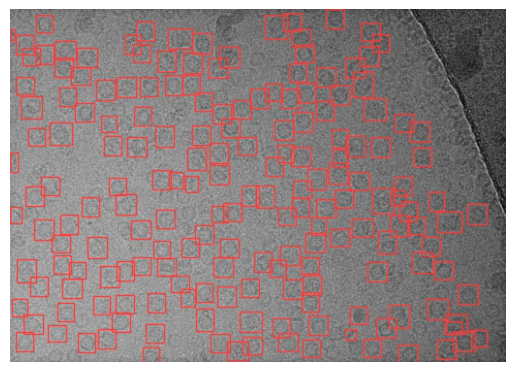

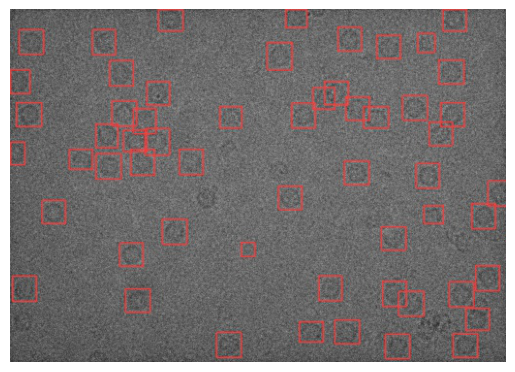

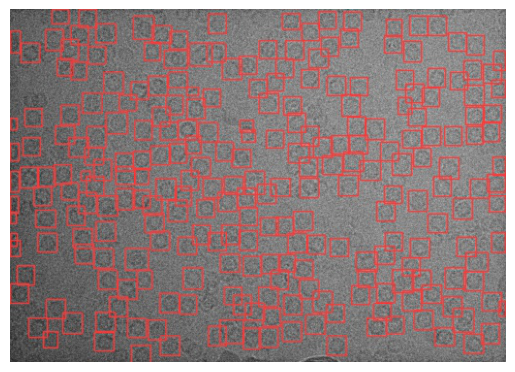

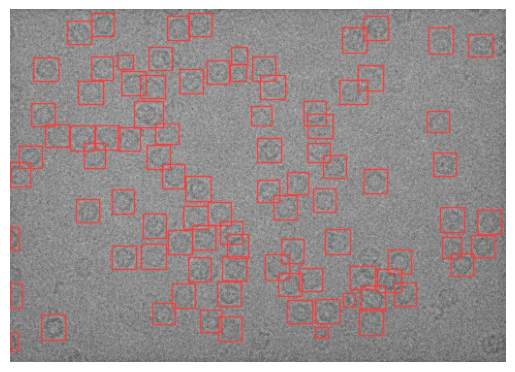

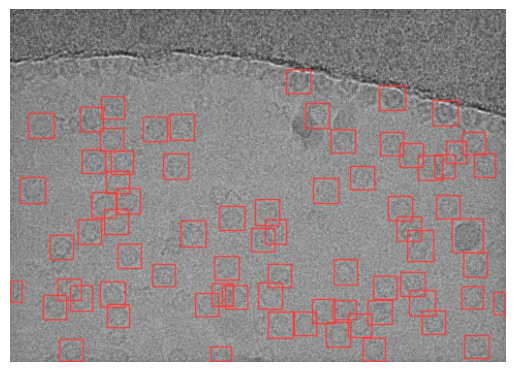

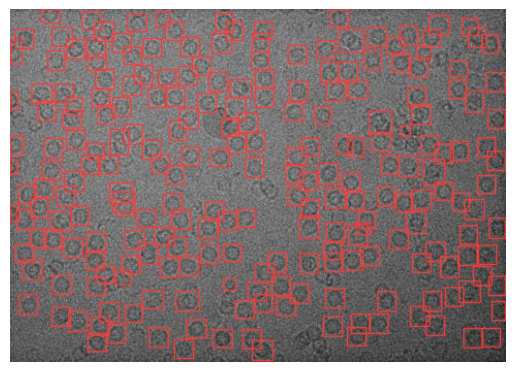

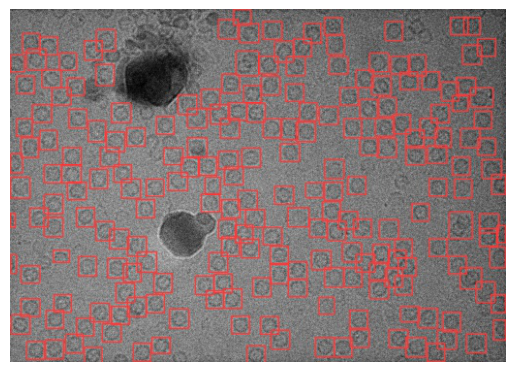

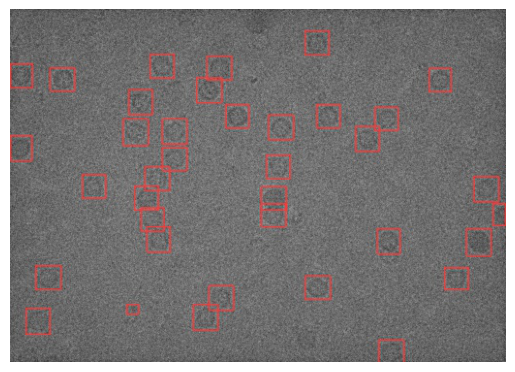

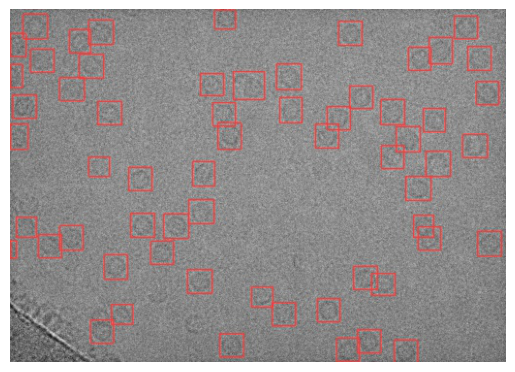

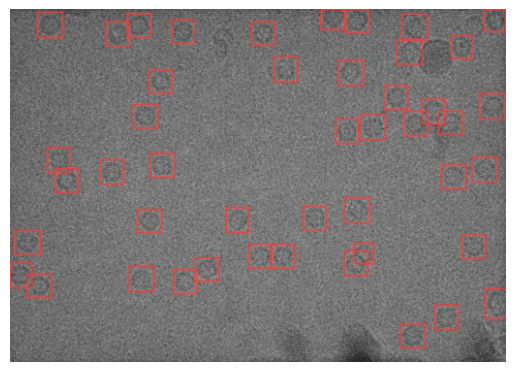

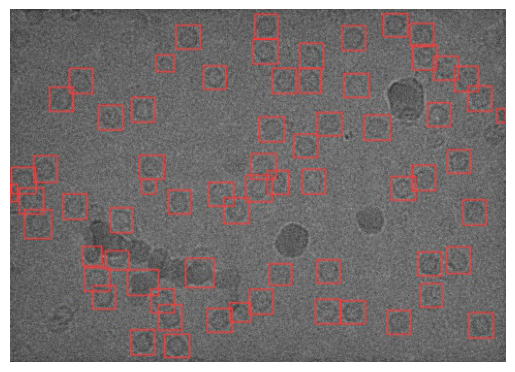

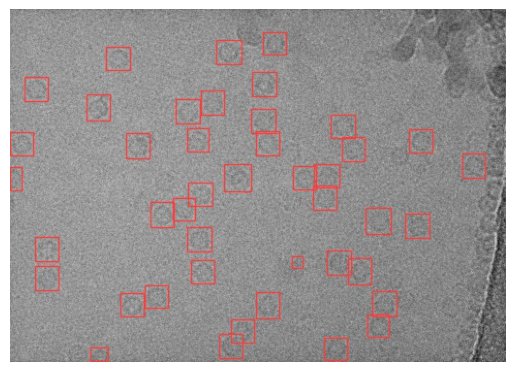

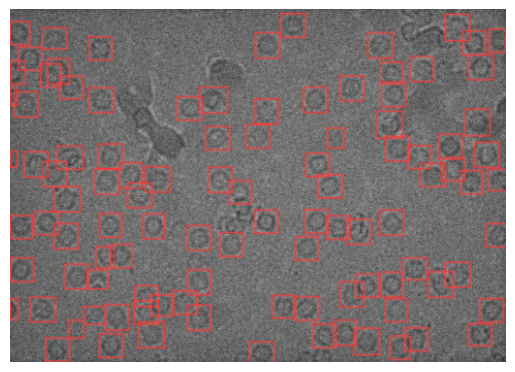

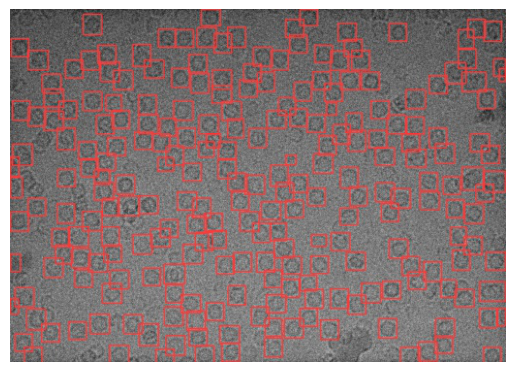

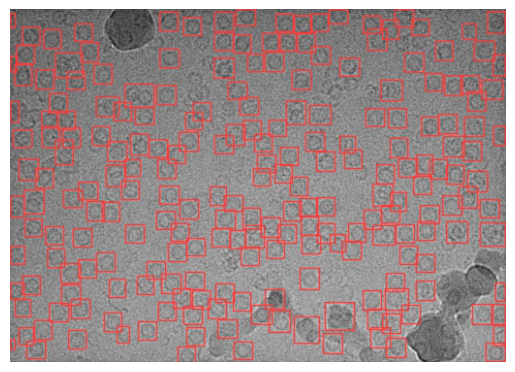

In [ ]:
import glob

directory_path = '/content/runs/detect/predict*'
file_paths = []

directories = glob.glob(directory_path)

for directory in directories:
    jpeg_files = glob.glob(directory + '/*.jpg')
    file_paths.extend(jpeg_files)

for file_path in file_paths:
  image = mpimg.imread(file_path)
  plt.imshow(image)
  plt.axis('off')
  plt.show()